In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

Cloning into 'clothing-dataset-small'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 384 (delta 0), pack-reused 3439
Receiving objects: 100% (3839/3839), 100.58 MiB | 44.90 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [4]:
from tensorflow.keras.preprocessing.image import load_img

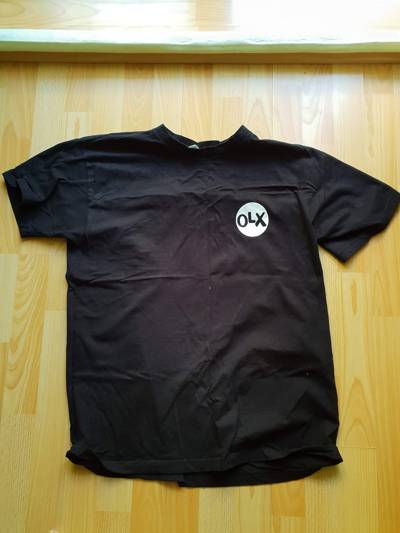

In [5]:
path = './clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = path + '/' + name
load_img(fullname)

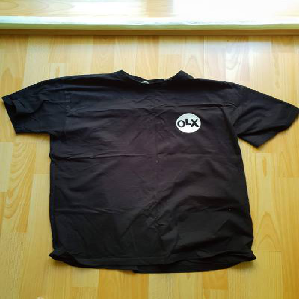

In [6]:
load_img(fullname, target_size=(299, 299))

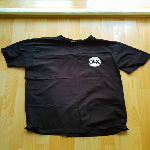

In [7]:
load_img(fullname, target_size=(150, 150))

In [8]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions

In [9]:
model = MobileNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3)
)

14540800/14536120 [==============================] - 0s 0us/step


In [10]:
img = load_img(fullname, target_size=(224, 224))
x = np.array(img)
x.shape

(224, 224, 3)

In [11]:
X = np.array([x])
X.shape

(1, 224, 224, 3)

In [12]:
X = preprocess_input(X)

In [13]:
pred = model.predict(X)

In [14]:
pred.shape

(1, 1000)

In [15]:
pred[0, :10]

array([4.09941480e-04, 2.64468781e-05, 3.97241201e-05, 2.50486919e-05,
       1.52267412e-05, 1.05674284e-04, 2.70545370e-05, 2.05104479e-05,
       1.28837783e-04, 1.15957148e-04], dtype=float32)

In [16]:
decode_predictions(pred)

40960/35363 [==================================] - 0s 0us/step


[[('n02916936', 'bulletproof_vest', 0.5632502),
  ('n04370456', 'sweatshirt', 0.1235053),
  ('n03595614', 'jersey', 0.117740825),
  ('n04235860', 'sleeping_bag', 0.08214963),
  ('n02769748', 'backpack', 0.02122801)]]

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
image_size = (150, 150)
batch_size = 32

In [19]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [20]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


In [21]:
base_model = MobileNetV2(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)

9412608/9406464 [==============================] - 0s 0us/step


In [22]:
base_model.trainable = False

In [23]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
vector = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vector)

model = keras.Model(inputs, outputs)

In [24]:
learning_rate = 0.01

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [25]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 16s 143ms/step - loss: 2.1415 - accuracy: 0.5853 - val_loss: 0.8695 - val_accuracy: 0.7947
Epoch 2/10
96/96 [==============================] - 12s 128ms/step - loss: 0.4612 - accuracy: 0.8671 - val_loss: 1.3783 - val_accuracy: 0.7302
Epoch 3/10
96/96 [==============================] - 12s 128ms/step - loss: 0.4567 - accuracy: 0.8773 - val_loss: 1.1573 - val_accuracy: 0.7537
Epoch 4/10
96/96 [==============================] - 12s 126ms/step - loss: 0.3168 - accuracy: 0.9089 - val_loss: 1.0303 - val_accuracy: 0.8006
Epoch 5/10
96/96 [==============================] - 12s 126ms/step - loss: 0.2519 - accuracy: 0.9313 - val_loss: 1.2356 - val_accuracy: 0.7947
Epoch 6/10
96/96 [==============================] - 12s 125ms/step - loss: 0.1152 - accuracy: 0.9610 - val_loss: 1.2283 - val_accuracy: 0.7977
Epoch 7/10
96/96 [==============================] - 12s 126ms/step - loss: 0.0960 - accuracy: 0.9655 - val_loss: 1.2531 - val_accuracy: 0.7977

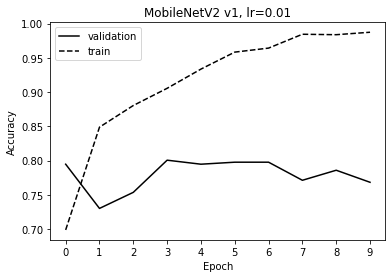

In [26]:
plt.figure(figsize=(6, 4))

epochs = history.epoch
val = history.history['val_accuracy']
train = history.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('MobileNetV2 v1, lr=0.01')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(np.arange(10))

plt.legend()


plt.savefig('mobilenetv2_v1_0_01.svg')

plt.show()

In [27]:
def make_model(learning_rate):
    base_model = MobileNetV2(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vector)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [28]:
model = make_model(learning_rate=0.001)
history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 15s 134ms/step - loss: 1.6632 - accuracy: 0.4772 - val_loss: 0.7094 - val_accuracy: 0.7566
Epoch 2/10
96/96 [==============================] - 12s 127ms/step - loss: 0.5488 - accuracy: 0.8099 - val_loss: 0.5645 - val_accuracy: 0.8035
Epoch 3/10
96/96 [==============================] - 12s 127ms/step - loss: 0.4241 - accuracy: 0.8623 - val_loss: 0.5517 - val_accuracy: 0.8123
Epoch 4/10
96/96 [==============================] - 12s 127ms/step - loss: 0.3427 - accuracy: 0.8977 - val_loss: 0.5270 - val_accuracy: 0.8152
Epoch 5/10
96/96 [==============================] - 12s 127ms/step - loss: 0.2506 - accuracy: 0.9331 - val_loss: 0.5279 - val_accuracy: 0.8123
Epoch 6/10
96/96 [==============================] - 12s 127ms/step - loss: 0.2544 - accuracy: 0.9272 - val_loss: 0.5024 - val_accuracy: 0.8065
Epoch 7/10
96/96 [==============================] - 12s 127ms/step - loss: 0.2102 - accuracy: 0.9466 - val_loss: 0.5147 - val_accuracy: 0.8006

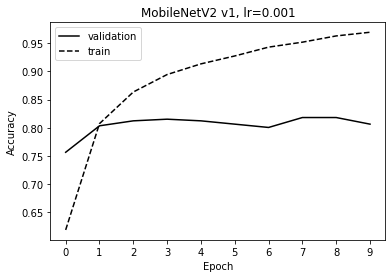

In [29]:
plt.figure(figsize=(6, 4))

epochs = history_0_001.epoch
val = history_0_001.history['val_accuracy']
train = history_0_001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('MobileNetV2 v1, lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('mobilenetv2_v1_0_001.svg')

plt.show()

In [30]:
model = make_model(learning_rate=0.0001)
history_0_0001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 15s 134ms/step - loss: 2.5288 - accuracy: 0.2004 - val_loss: 1.7058 - val_accuracy: 0.4457
Epoch 2/10
96/96 [==============================] - 12s 127ms/step - loss: 1.5551 - accuracy: 0.4862 - val_loss: 1.3210 - val_accuracy: 0.5836
Epoch 3/10
96/96 [==============================] - 12s 127ms/step - loss: 1.1960 - accuracy: 0.6076 - val_loss: 1.0959 - val_accuracy: 0.6305
Epoch 4/10
96/96 [==============================] - 12s 127ms/step - loss: 1.0252 - accuracy: 0.6785 - val_loss: 0.9620 - val_accuracy: 0.6716
Epoch 5/10
96/96 [==============================] - 12s 128ms/step - loss: 0.8868 - accuracy: 0.7174 - val_loss: 0.8719 - val_accuracy: 0.7155
Epoch 6/10
96/96 [==============================] - 12s 128ms/step - loss: 0.7808 - accuracy: 0.7737 - val_loss: 0.8020 - val_accuracy: 0.7361
Epoch 7/10
96/96 [==============================] - 12s 127ms/step - loss: 0.7283 - accuracy: 0.7652 - val_loss: 0.7535 - val_accuracy: 0.7478

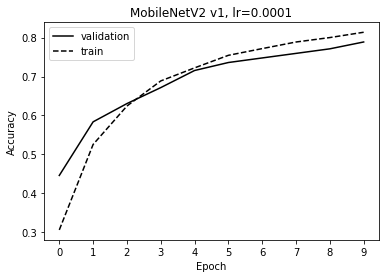

In [31]:
plt.figure(figsize=(6, 4))

epochs = history_0_0001.epoch
val = history_0_0001.history['val_accuracy']
train = history_0_0001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('MobileNetV2 v1, lr=0.0001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('mobilenetv2_v1_0_0001.svg')

plt.show()

In [32]:
epochs = np.arange(10)
val_0_01 = history.history['val_accuracy']
val_0_001 = history_0_001.history['val_accuracy']
val_0_0001 = history_0_0001.history['val_accuracy']

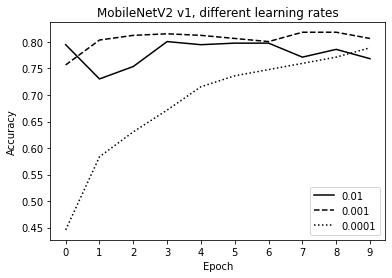

In [33]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val_0_01, color='black', linestyle='solid', label='0.01')
plt.plot(epochs, val_0_001, color='black', linestyle='dashed', label='0.001')
plt.plot(epochs, val_0_0001, color='black', linestyle='dotted', label='0.0001')


plt.title('MobileNetV2 v1, different learning rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()

plt.savefig('mobilenetv2_v1_all_lr.svg')

plt.show()

In [ ]:
model = make_model(learning_rate=0.001)

In [35]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "mobilenetv2_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
96/96 [==============================] - 15s 136ms/step - loss: 1.5802 - accuracy: 0.5024 - val_loss: 0.6503 - val_accuracy: 0.7742
Epoch 2/10
96/96 [==============================] - 12s 127ms/step - loss: 0.5591 - accuracy: 0.8064 - val_loss: 0.5378 - val_accuracy: 0.7977
Epoch 3/10
96/96 [==============================] - 12s 127ms/step - loss: 0.3991 - accuracy: 0.8727 - val_loss: 0.5331 - val_accuracy: 0.8123
Epoch 4/10
96/96 [==============================] - 12s 127ms/step - loss: 0.3604 - accuracy: 0.8836 - val_loss: 0.5507 - val_accuracy: 0.7889
Epoch 5/10
96/96 [==============================] - 12s 128ms/step - loss: 0.2778 - accuracy: 0.9182 - val_loss: 0.5115 - val_accuracy: 0.8270
Epoch 6/10
96/96 [==============================] - 12s 127ms/step - loss: 0.2575 - accuracy: 0.9295 - val_loss: 0.4940 - val_accuracy: 0.8152
Epoch 7/10
96/96 [==============================] - 12s 127ms/step - loss: 0.1931 - accuracy: 0.9522 - val_loss: 0.5216 - val_accuracy: 0.7977

In [36]:
def make_model(learning_rate, droprate):
    base_model = MobileNetV2(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [ ]:
model = make_model(learning_rate=0.001, droprate=0.0)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "mobilenetv2_v2_0_0_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

In [38]:
history_0 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
96/96 [==============================] - 15s 134ms/step - loss: 1.2316 - accuracy: 0.5886 - val_loss: 0.6530 - val_accuracy: 0.7830
Epoch 2/30
96/96 [==============================] - 12s 126ms/step - loss: 0.4193 - accuracy: 0.8524 - val_loss: 0.5022 - val_accuracy: 0.8182
Epoch 3/30
96/96 [==============================] - 12s 127ms/step - loss: 0.2780 - accuracy: 0.9047 - val_loss: 0.5478 - val_accuracy: 0.8065
Epoch 4/30
96/96 [==============================] - 12s 127ms/step - loss: 0.1755 - accuracy: 0.9495 - val_loss: 0.5571 - val_accuracy: 0.8035
Epoch 5/30
96/96 [==============================] - 12s 127ms/step - loss: 0.1066 - accuracy: 0.9784 - val_loss: 0.5440 - val_accuracy: 0.8094
Epoch 6/30
96/96 [==============================] - 12s 125ms/step - loss: 0.0775 - accuracy: 0.9875 - val_loss: 0.5939 - val_accuracy: 0.8094
Epoch 7/30
96/96 [==============================] - 12s 125ms/step - loss: 0.0621 - accuracy: 0.9913 - val_loss: 0.5398 - val_accuracy: 0.8094

In [39]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "mobilenetv2_v2_0_2_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_1 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
96/96 [==============================] - 15s 133ms/step - loss: 1.7340 - accuracy: 0.5084 - val_loss: 0.6407 - val_accuracy: 0.8065
Epoch 2/30
96/96 [==============================] - 12s 124ms/step - loss: 0.5769 - accuracy: 0.8117 - val_loss: 0.5473 - val_accuracy: 0.8182
Epoch 3/30
96/96 [==============================] - 12s 125ms/step - loss: 0.4235 - accuracy: 0.8544 - val_loss: 0.4782 - val_accuracy: 0.8240
Epoch 4/30
96/96 [==============================] - 12s 125ms/step - loss: 0.3212 - accuracy: 0.9004 - val_loss: 0.4814 - val_accuracy: 0.8211
Epoch 5/30
96/96 [==============================] - 12s 125ms/step - loss: 0.2448 - accuracy: 0.9212 - val_loss: 0.4689 - val_accuracy: 0.8270
Epoch 6/30
96/96 [==============================] - 12s 125ms/step - loss: 0.2079 - accuracy: 0.9369 - val_loss: 0.4515 - val_accuracy: 0.8358
Epoch 7/30
96/96 [==============================] - 12s 127ms/step - loss: 0.1556 - accuracy: 0.9499 - val_loss: 0.4811 - val_accuracy: 0.8211

In [40]:
model = make_model(learning_rate=0.001, droprate=0.5)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "mobilenetv2_v2_0_5_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_2 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
96/96 [==============================] - 15s 136ms/step - loss: 1.9191 - accuracy: 0.4086 - val_loss: 0.6695 - val_accuracy: 0.7771
Epoch 2/30
96/96 [==============================] - 12s 127ms/step - loss: 0.8258 - accuracy: 0.7239 - val_loss: 0.5925 - val_accuracy: 0.8065
Epoch 3/30
96/96 [==============================] - 12s 128ms/step - loss: 0.6728 - accuracy: 0.7761 - val_loss: 0.5227 - val_accuracy: 0.8299
Epoch 4/30
96/96 [==============================] - 12s 127ms/step - loss: 0.5497 - accuracy: 0.8182 - val_loss: 0.4956 - val_accuracy: 0.8328
Epoch 5/30
96/96 [==============================] - 12s 126ms/step - loss: 0.5045 - accuracy: 0.8348 - val_loss: 0.4857 - val_accuracy: 0.8240
Epoch 6/30
96/96 [==============================] - 12s 126ms/step - loss: 0.4365 - accuracy: 0.8425 - val_loss: 0.4704 - val_accuracy: 0.8358
Epoch 7/30
96/96 [==============================] - 12s 127ms/step - loss: 0.3947 - accuracy: 0.8620 - val_loss: 0.4603 - val_accuracy: 0.8563

In [41]:
model = make_model(learning_rate=0.001, droprate=0.8)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "mobilenetv2_v2_0_8_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_3 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
96/96 [==============================] - 15s 134ms/step - loss: 2.5386 - accuracy: 0.2599 - val_loss: 1.2667 - val_accuracy: 0.5513
Epoch 2/30
96/96 [==============================] - 12s 127ms/step - loss: 1.5693 - accuracy: 0.4601 - val_loss: 0.9863 - val_accuracy: 0.6804
Epoch 3/30
96/96 [==============================] - 12s 128ms/step - loss: 1.2876 - accuracy: 0.5458 - val_loss: 0.8941 - val_accuracy: 0.7126
Epoch 4/30
96/96 [==============================] - 12s 128ms/step - loss: 1.2713 - accuracy: 0.5309 - val_loss: 0.7906 - val_accuracy: 0.7507
Epoch 5/30
96/96 [==============================] - 12s 129ms/step - loss: 1.1799 - accuracy: 0.5715 - val_loss: 0.7622 - val_accuracy: 0.7625
Epoch 6/30
96/96 [==============================] - 12s 128ms/step - loss: 1.1112 - accuracy: 0.5819 - val_loss: 0.7267 - val_accuracy: 0.7449
Epoch 7/30
96/96 [==============================] - 12s 127ms/step - loss: 1.0773 - accuracy: 0.6140 - val_loss: 0.6689 - val_accuracy: 0.7654

In [42]:
epochs = history_0.epoch

train00 = history_0.history['accuracy']
train02 = history_1.history['accuracy']
train05 = history_2.history['accuracy']
train08 = history_3.history['accuracy']

val00 = history_0.history['val_accuracy']
val02 = history_1.history['val_accuracy']
val05 = history_2.history['val_accuracy']
val08 = history_3.history['val_accuracy']

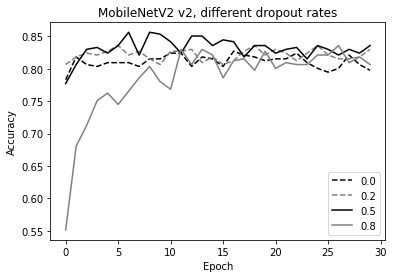

In [43]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, val02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, val05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, val08, color='grey', linestyle='solid', label='0.8')


plt.title('MobileNetV2 v2, different dropout rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('mobilenetv2_v2_dropout.svg')

plt.show()

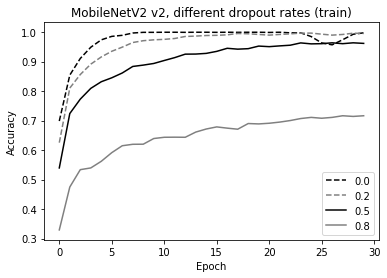

In [44]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, train00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, train02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, train05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, train08, color='grey', linestyle='solid', label='0.8')


plt.title('MobileNetV2 v2, different dropout rates (train)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('mobilenetv2_v2_dropout_train.svg')

plt.show()

In [45]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


In [46]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,  
)

train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [47]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "mobilenetv2_v3_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=callbacks)

Epoch 1/50
96/96 [==============================] - 27s 257ms/step - loss: 1.5969 - accuracy: 0.5078 - val_loss: 0.6476 - val_accuracy: 0.7771
Epoch 2/50
96/96 [==============================] - 24s 249ms/step - loss: 0.6105 - accuracy: 0.7987 - val_loss: 0.5724 - val_accuracy: 0.7977
Epoch 3/50
96/96 [==============================] - 24s 248ms/step - loss: 0.5217 - accuracy: 0.8225 - val_loss: 0.5324 - val_accuracy: 0.8152
Epoch 4/50
96/96 [==============================] - 24s 249ms/step - loss: 0.4452 - accuracy: 0.8423 - val_loss: 0.5330 - val_accuracy: 0.8240
Epoch 5/50
96/96 [==============================] - 24s 250ms/step - loss: 0.3820 - accuracy: 0.8682 - val_loss: 0.5372 - val_accuracy: 0.7889
Epoch 6/50
96/96 [==============================] - 24s 248ms/step - loss: 0.3351 - accuracy: 0.8876 - val_loss: 0.5062 - val_accuracy: 0.8152
Epoch 7/50
96/96 [==============================] - 24s 248ms/step - loss: 0.3101 - accuracy: 0.8930 - val_loss: 0.4920 - val_accuracy: 0.8211

In [48]:
epochs = history.epoch
accuracy = history.history['val_accuracy']

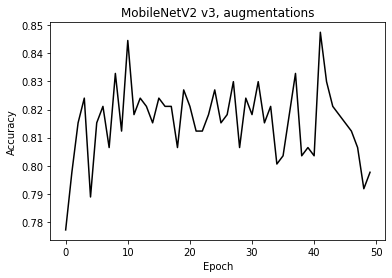

In [49]:
plt.plot(epochs, accuracy, color='black', linestyle='solid')


plt.title('MobileNetV2 v3, augmentations')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig('mobilenetv2_v3_aug.svg')

plt.show()

In [50]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [51]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [52]:
labels = {
    0: 'dress',
    1: 'hat',
    2: 'longsleeve',
    3: 'outwear',
    4: 'pants',
    5: 'shirt',
    6: 'shoes',
    7: 'shorts',
    8: 'skirt',
    9: 't-shirt'
}

In [53]:
image_size = (150, 150)

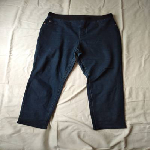

In [54]:
path = 'clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'
img = load_img(path, target_size=(image_size))
img

In [55]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

In [56]:
pred = model.predict(X)
pred[0]

array([ -4.700759 , -10.10823  ,  -3.8362265,  -4.513137 ,  14.545028 ,
        -4.875928 ,  -4.1853366,   7.6834636,  -6.197115 ,  -3.5038943],
      dtype=float32)

In [57]:
pred[0].argmax()

4

In [58]:
labels[pred[0].argmax()]

'pants'

In [59]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    "clothing-dataset-small/test",
    shuffle=False,
    target_size=image_size,
    batch_size=32,
)

Found 372 images belonging to 10 classes.


In [60]:
model.evaluate(test_ds)

12/12 [==============================] - 2s 143ms/step - loss: 1.1141 - accuracy: 0.7849


[1.1140809059143066, 0.7849462628364563]

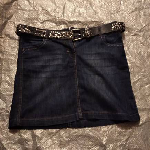

In [61]:
path = '/content/clothing-dataset-small/test/skirt/491982c3-3e90-431e-99e6-b14ecea36384.jpg'
img = load_img(path, target_size=(image_size))
img

In [62]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

In [63]:
pred = model.predict(X)
pred[0]

array([-3.6100109 , -7.583029  , -8.270692  , -6.604907  ,  0.67619276,
       -5.4378743 , -5.0998096 ,  2.773016  ,  5.3083735 ,  2.4020495 ],
      dtype=float32)

In [64]:
pred[0].argmax()

8

In [65]:
labels[pred[0].argmax()]

'skirt'

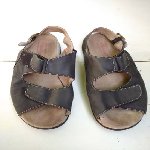

In [66]:
path = '/content/clothing-dataset-small/test/shoes/2174d585-e8cf-43ce-bb61-de1567c74fd5.jpg'
img = load_img(path, target_size=(image_size))
img

In [67]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

In [68]:
pred = model.predict(X)
pred[0]

array([-27.518751 ,   3.2535822, -12.381219 ,  -1.8887514,  -1.2285957,
       -19.840904 ,  35.786564 , -12.575069 , -21.645254 , -22.231836 ],
      dtype=float32)

In [69]:
pred[0].argmax()

6

In [70]:
labels[pred[0].argmax()]

'shoes'

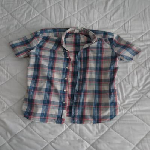

In [71]:
path = '/content/clothing-dataset-small/test/shirt/5089843a-ecf8-4cb6-8f35-587f19125046.jpg'
img = load_img(path, target_size=(image_size))
img

In [72]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

pred = model.predict(X)
pred[0]

array([ -1.7563057 , -16.963184  ,   0.62764406,  -5.9332504 ,
        -7.104201  ,   6.257236  ,  -4.107408  ,  -5.444402  ,
        -6.897951  ,   4.895687  ], dtype=float32)

In [73]:
pred[0].argmax()

5

In [74]:
labels[pred[0].argmax()]

'shirt'

In [75]:
#Import your test images to colab. I use pinterest to store the the images. 
%mkdir /content/test/
%cd /content/test/

!curl -L "https://images.unsplash.com/photo-1572804013309-59a88b7e92f1?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=684&q=80.jpg" > test.jpeg;

/content/test
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 89258  100 89258    0     0   751k      0 --:--:-- --:--:-- --:--:--  751k


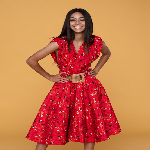

In [76]:
path = '/content/test/test.jpeg'
img = load_img(path, target_size=(image_size))
img

In [77]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

pred = model.predict(X)
pred[0]

array([ 12.462189 ,  -5.066344 ,  -1.3200252,   5.7223115,  -3.4465098,
         2.207941 ,  -8.561941 ,  -8.219749 ,  -0.6005318, -10.839247 ],
      dtype=float32)

In [78]:
pred[0].argmax()

0

In [79]:
labels[pred[0].argmax()]

'dress'

In [80]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 6.9MB/s 
     |████████████████████████████████| 112kB 13.2MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0


In [81]:
model.save("model.h5")

In [82]:
!tensorflowjs_converter --input_format=keras /content/test/model.h5 /tmp/tfjs_model

2021-04-23 02:25:13.905000: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [83]:
!tensorflowjs_converter --input_format tfjs_layers_model --output_format tfjs_graph_model /tmp/tfjs_model/model.json graph_model

2021-04-23 02:25:32.258922: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-04-23 02:25:33.993917: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-23 02:25:33.994844: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-23 02:25:34.000463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-23 02:25:34.001020: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-04-23 02:25:34.001062: I tensorflow/stream_executor/platform/default/dso_loade